In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DataLoad():
    def __init__(self, model:str, topic:str, data_path:str, rev_topic: bool=False):
        self.model = model
        self.topic = topic
        self.path = data_path

        if rev_topic:
            self.topic += ' (Rev. Framing)'

        self.R = np.load(data_path + 'all_R.npy')
        self.probs = np.load(data_path + 'all_probs.npy')

        ### remove external probing for now:
        self.R = self.R[:,:,:,:,0,:]

        self.mask = (self.R[:, :, :, :, 0] == -1)
        print(f"Irregular Runs: {self.mask.sum() / np.prod(self.R.shape[:3]) * 100:0.2f} %")
        self.R[self.mask] = np.nan

    def print_datashape(self):
        print("(#pairs, #runs, #discussion_rounds + 1 init round, #agents, #features)\n", self.R.shape)

In [3]:
base_path = '../../data/simulations/raw/dolphin_mixtral/'
paths = ['climate_change', 'ai_dangers', 'wealth_distribution', 'climate_change_rev', 'ai_dangers_rev', 'wealth_distribution_rev']

all_data = np.zeros((6, 25, 25, 6, 2, 3))

for p, path in enumerate(paths):
    data = DataLoad('DolphinMixtral', 'Climate Change', base_path + path + '/', p % 2 == 1)
    all_data[p] = data.R

Irregular Runs: 0.77 %
Irregular Runs: 0.37 %
Irregular Runs: 0.56 %
Irregular Runs: 0.93 %
Irregular Runs: 0.24 %
Irregular Runs: 0.69 %


In [4]:
from scipy.optimize import brentq

# ----------------------------------------------------------
# 1) Helpers: Shannon Entropy, etc.
# ----------------------------------------------------------

def shannon_entropy(p, eps=1e-15):
    """
    Compute Shannon entropy in base 2 of a discrete distribution p.
    p is a 1D iterable of probabilities (must sum to 1).
    eps is a small number to avoid log(0).
    """
    p = np.array(p, dtype=float)
    p = np.clip(p, eps, 1.0)  # avoid log(0)
    return -np.sum(p * np.log2(p))


# ----------------------------------------------------------
# 2) Minimal Entropy Distribution
# ----------------------------------------------------------
#
# The minimal-entropy distribution that achieves mean m
# under X in {-2, -1, 0, 1, 2} is always supported on at most two points.
# Specifically, for each sub-interval:
#    m in [-2, -1] -> mix of -2 and -1
#    m in [-1,  0] -> mix of -1 and  0
#    m in [ 0,  1] -> mix of  0 and  1
#    m in [ 1,  2] -> mix of  1 and  2
# If m is exactly one of {-2, -1, 0, 1, 2}, a degenerate distribution p_x=1 
# at that point yields zero entropy (the global minimum).

def minimal_entropy(m):
    """
    Return minimal Shannon entropy (base 2) for a distribution on {-2,-1,0,1,2} 
    with mean m in [-2,2].
    """
    # If m is exactly an integer in [-2,2], the degenerate distribution at that point has 0 entropy.
    if np.isclose(m, -2): return 0.0
    if np.isclose(m, -1): return 0.0
    if np.isclose(m,  0): return 0.0
    if np.isclose(m,  1): return 0.0
    if np.isclose(m,  2): return 0.0
    
    # Initialize the probability vector
    p = np.zeros(5)  # order: p[-2], p[-1], p[0], p[1], p[2]
    
    # We'll find which two adjacent points to mix.
    values = np.array([-2, -1, 0, 1, 2], dtype=float)
    
    # Case 1: m in [-2, -1]
    if -2 <= m < -1:
        # we want a, b with a + b = 1, a * (-2) + b * (-1) = m
        # let a = x, b = 1 - x
        # => -2x + -1(1 - x) = m => -2x -1 + x = m => -x -1 = m => x = -(m+1)
        x = - (m + 1)
        p[0] = x          # p_{-2}
        p[1] = 1.0 - x    # p_{-1}
    
    # Case 2: m in [-1, 0]
    elif -1 <= m < 0:
        # Mix of -1 and 0
        # let a = x, b = 1 - x
        # => -1*x + 0*(1 - x) = m => -x = m => x = -m
        x = -m
        p[1] = x        # p_{-1}
        p[2] = 1.0 - x  # p_{0}
    
    # Case 3: m in [0, 1]
    elif 0 <= m < 1:
        # Mix of 0 and 1
        # let a = x, b = 1 - x
        # => 0*x + 1*(1 - x) = m => 1 - x = m => x = 1 - m
        x = 1.0 - m
        p[2] = x       # p_{0}
        p[3] = 1.0 - x # p_{1}
    
    # Case 4: m in [1, 2]
    elif 1 <= m < 2:
        # Mix of 1 and 2
        # => 1*x + 2*(1 - x) = m => x + 2 - 2x = m => 2 - x = m => x = 2 - m
        x = 2.0 - m
        p[3] = x
        p[4] = 1.0 - x
    
    # Numeric safety: ensure p sums to 1
    p = np.maximum(p, 0.0)
    p /= np.sum(p)
    
    return shannon_entropy(p)


# ----------------------------------------------------------
# 3) Maximum Entropy Distribution
# ----------------------------------------------------------
#
# The max-entropy distribution subject to a mean constraint 
# on X in {-2, -1, 0, 1, 2} is a Gibbs distribution:
#       p_i = e^(beta * i) / Z,  where 
#       Z = sum_{k in {-2..2}} e^(beta * k), 
# and beta is chosen so that E[X] = m.

def mean_of_beta(beta, values):
    """
    Given beta and possible values (e.g. [-2, -1, 0, 1, 2]),
    return the mean E[X] = sum( x * e^(beta*x) ) / sum( e^(beta*x) ).
    """
    w = np.exp(beta * values)
    return np.sum(values * w) / np.sum(w)

def maxent_entropy(m):
    """
    Return the maximum Shannon entropy (base 2) for a distribution on {-2,-1,0,1,2}
    with mean m. Solves for beta numerically and computes the distribution.
    """
    values = np.array([-2, -1, 0, 1, 2], dtype=float)
    
    # Special extremes: 
    # if m = -2 or 2, the unique distribution is degenerate => entropy = 0
    if np.isclose(m, -2) or np.isclose(m, 2):
        return 0.0
    
    # If m is exactly in the middle 0 => symmetrical => beta=0 => uniform distribution
    # => entropy = log2(5). But let's not treat it separately; the solver can find it.
    
    # We solve mean_of_beta(beta, values) = m for beta.
    # The function f(beta) = E[X] - m. We'll bracket a reasonable range for beta.
    
    def f(beta):
        return mean_of_beta(beta, values) - m
    
    # The mean_of_beta function is monotonic in beta for values symmetric around 0:
    #   - for large negative beta, distribution heavily favors 2 => E[X] close to 2
    #   - for large positive beta, distribution heavily favors -2 => E[X] close to -2
    # Actually, be mindful of signs: 
    #   * large positive beta => e^(beta * -2) is small if -2 is negative ... Actually, let's just bracket widely.
    # We'll pick an interval [beta_min, beta_max] to bracket the root, e.g. [-100, 100].
    
    beta_min, beta_max = -100.0, 100.0
    beta_star = brentq(f, beta_min, beta_max)
    
    # Now compute the distribution p_i
    w = np.exp(beta_star * values)
    Z = np.sum(w)
    p = w / Z
    
    # Return Shannon entropy in base 2
    return shannon_entropy(p)


# ----------------------------------------------------------
# 4) Generate Data
# ----------------------------------------------------------

# We'll take 201 points in [-2,2]
m_values = np.linspace(-2, 2, 201)

H_min_values = []
H_max_values = []

for m in m_values:
    H_min_values.append(minimal_entropy(m))
    H_max_values.append(maxent_entropy(m))

# Convert to numpy arrays
H_min_values = np.array(H_min_values)
H_max_values = np.array(H_max_values)

colors = plt.cm.get_cmap('viridis', 6)
from matplotlib.colors import Normalize
norm_entropy = Normalize(vmin=np.nanmin(H_min_values), vmax=np.nanmax(H_max_values))

/tmp/ipykernel_308098/2754466379.py:168: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', 6)


/tmp/ipykernel_308098/581698033.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis_r', 6)


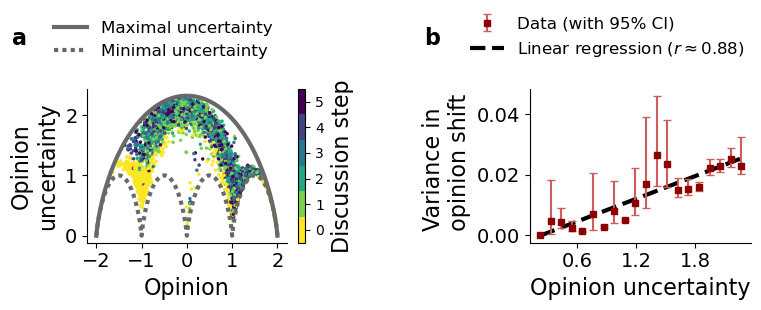

In [ ]:
from matplotlib import cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8.57, 2))
fig.subplots_adjust(wspace=1)

# --- Plot 1 ---
ax1.plot(m_values, H_max_values, label='Maximal uncertainty', color='dimgrey', lw=3)
ax1.plot(m_values, H_min_values, label='Minimal uncertainty', color='dimgrey', ls=(0, (1, 1)), lw=3)

data = all_data[0]

bounds = np.arange(-0.5, 6.5, 1)  # Edges for 6 bins [0–5]
norm = BoundaryNorm(bounds, ncolors=6)
cmap = cm.get_cmap('viridis_r', 6)
sc = ax1.scatter([], [], c=[], cmap=cmap, norm=norm)


x_ = np.moveaxis(data[..., :, :, 0], -2, 0).reshape(6, -1)
y_ = np.moveaxis(data[..., :, :, 2], -2, 0).reshape(6, -1)
labels = np.repeat(np.arange(6), x_.shape[1])

x = x_.reshape(-1) - 3
y = y_.reshape(-1) * 1.4427

rng = np.random.default_rng(0)  # seed for reproducibility
perm = rng.permutation(x.size)

x = x[perm]
y = y[perm]
labels = labels[perm]

ax1.scatter(x, y, c=labels, cmap=cmap, norm=norm,
            alpha=1, s=25, marker='.', edgecolors='none')


sc = ax1.scatter([], [], c=[], cmap=cmap, norm=norm)

# Update colorbar
cbar = fig.colorbar(sc, ax=ax1, orientation='vertical', fraction=0.05, pad=0.05, ticks=np.arange(6))
cbar.set_label('Discussion step', fontsize=16, labelpad=5)
cbar.ax.tick_params(labelsize=10)
cbar.ax.tick_params(which='minor', length=0)


ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Opinion\nuncertainty', fontsize=16)  # No label
ax1.set_xlabel(r'Opinion', fontsize=16)
ax1.set_xticks(np.arange(-2, 3))
ax1.tick_params(axis='both', labelsize=14)
ax1.legend(loc=(-0.2, 1.15), ncols=1, frameon=False, fontsize=12)

# --- Plot 2 ---
data = np.load('../../data/simulations/processed/opinion_uncertainty/binned_variance_data.npz')
bin_centers = data['bin_centers']
binned_variance = data['variance']
y_pred = data['regression_pred']

ci_low = np.load('../../data/simulations/processed/opinion_uncertainty/ci_low.npy')
ci_high = np.load('../../data/simulations/processed/opinion_uncertainty/ci_high.npy')

lower = np.maximum(binned_variance - ci_low, 0)
upper = np.maximum(ci_high - binned_variance, 0)
yerr = np.array([lower, upper]).reshape(2, -1)

ax2.errorbar(bin_centers, binned_variance, yerr=yerr, ms=5, fmt='s', ecolor='indianred', 
             mfc='darkred', mec='darkred', elinewidth=1.5, capsize=3, zorder=0, label='Data (with 95% CI)')
ax2.plot(bin_centers, y_pred, linestyle='--', linewidth=3, label=r'Linear regression ($r\approx0.88$)', color='black', zorder=-1)

ax2.set_xlabel('Opinion uncertainty', fontsize=16)
ax2.set_ylabel('Variance in \n opinion shift', fontsize=16)
ax2.tick_params(axis='both', labelsize=14)
ax2.spines[['right', 'top']].set_visible(False)
ax2.spines[['left', 'bottom']].set_color('black')


handles, labels = ax2.get_legend_handles_labels()
order = [1,0]

ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=(-0.3, 1.15), fontsize=12, frameon=False)
ax2.xaxis.set_major_locator(MaxNLocator(nbins=4))


ax1.text(-0.38, 1.4, 'a', transform=ax1.transAxes,
         fontsize=16, fontweight='bold', va='top', ha='left')

ax2.text(-0.48, 1.4, 'b', transform=ax2.transAxes,
         fontsize=16, fontweight='bold', va='top', ha='left')



plt.savefig('../../plots/figure_7.png', dpi=400, bbox_inches='tight')
plt.show()